In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
plt.ion()
%matplotlib inline

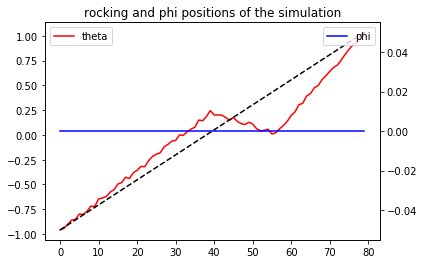

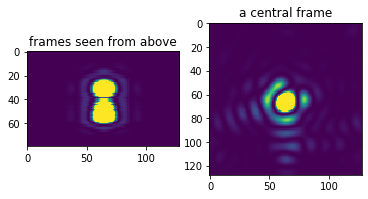

In [4]:
### load generated data
filename = 'generated_data_1.npz'
data = np.load(filename)['frames'] * 1e-6
shape = data.shape[-1]
o = np.load(filename)['offsets']
ax = plt.gca()
ax.plot(o, 'r', label='theta')
ax.plot([0, len(o)-1], [o.min(), o.max()], 'k--')
r = -np.load(filename)['rolls']
ax0twin = plt.twinx(ax)
ax0twin.plot(r, 'b', label='phi')
ax0twin.legend(loc='upper right')
ax.legend(loc='upper left')
ax.set_title('rocking and phi positions of the simulation')
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(np.abs(data[:,64,:]), vmax=np.abs(data[:,64,:]).max()/10)
ax[1].imshow(np.abs(data[len(data)//2,:,:]), vmax=np.abs(data[len(data)//2]).max()/10)
ax[0].set_title('frames seen from above')
ax[1].set_title('a central frame')
None

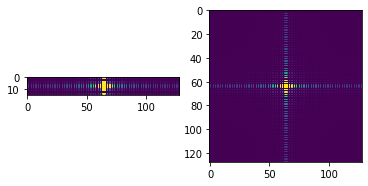

In [20]:
### build the initial model from the autocorrelation envelope

# number of angular bins in the model
N = 15

# the actual envelope - need to figure out the pixel sizes of the autocorrelation...
envelope = np.ones((N, shape, shape), dtype=int)
n1, n2 = N//4, shape//4
envelope[n1:-n1] = 0
envelope[:, n2:-n2] = 0
envelope[:, :, n2:-n2] = 0

# the initial model
shape = data.shape[-1]
ft = np.ones((N, shape, shape)) * envelope
W = np.fft.fftshift(np.fft.ifftn(ft))

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(np.abs(W[:,:,shape//2]), vmax=np.max(np.abs(W[:,:,shape//2]))/10)
ax[1].imshow(np.abs(W[N//2,:,:]), vmax=np.max(np.abs(W[N//2,:,:]))/10)

In [21]:
def first_axis_com(a):
    """
    Calculates the center of mass of an array along each column.
    """
    inds = np.arange(a.shape[0], dtype=int).reshape((-1, 1))
    return np.sum(a*inds, axis=0) / np.sum(a, axis=0)

<IPython.core.display.Javascript object>


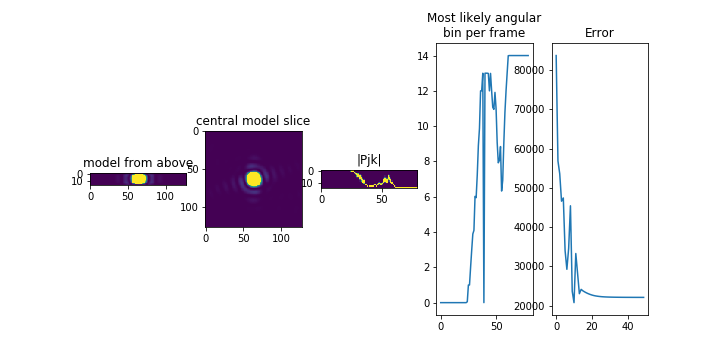

0 83709.79669390219
1 56871.789552764676
2 53588.15676197363
3 46616.712658549535
4 47435.99877519826
5 34023.84499207854
6 29264.969942895546
7 34627.015514643506
8 45445.19813123276
9 23669.3287112951
10 20776.411092383998
11 33292.57003059969
12 28218.727912194012
13 23055.98575771951
14 24157.05191188975
15 23778.718780440577
16 23503.96460071598
17 23262.262492384234
18 23053.794977376427
19 22871.30185936062
20 22719.151636205817
21 22595.428063227286
22 22499.023110306396
23 22422.992116952188
24 22362.866279024
25 22314.15901136024
26 22275.745621519924
27 22245.76030124578
28 22222.641717863386
29 22204.440554537265
30 22189.6016158416
31 22177.333620968737
32 22167.05064775959
33 22158.68613523072
34 22151.717074156182
35 22145.85110177157
36 22140.904427855876
37 22136.71273908079
38 22133.153830647407
39 22130.118840366344
40 22127.5278913442
41 22125.31333411116
42 22123.418912573612
43 22121.79764465802
44 22120.409991111213
45 22119.222421784914
46 22118.206286783156
47 

<IPython.core.display.Javascript object>


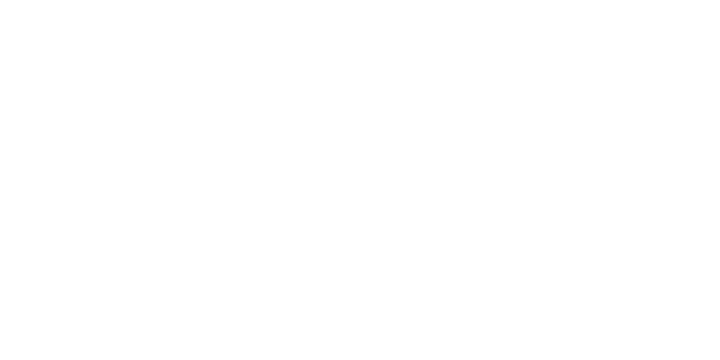

In [22]:
### iteration time!
%matplotlib notebook
Rjk = np.empty((N, len(data)), dtype=np.complex128)
wjk = np.zeros_like(Rjk, dtype=float)
priors = np.linspace(0, N, len(data))
fig, ax = plt.subplots(ncols=5, figsize=(10,5))
errors = []
for i in range(50):
    # M
    # first, calculate the probabilities Pjk based on the current model
    W[:] = W / np.mean(np.abs(W)) * np.mean(data)
    for j in range(N):
        for k in range(len(data)):
            Rjk[j, k] = np.exp(np.sum(data[k] * np.log10(W[j]+1e-6) - W[j]))
            # prior weight for each observation biased towards where it was placed last time:
            wjk[j, k] = np.exp(-np.abs(j-priors[k])/1.)
    Pjk = wjk*Rjk / np.sum(wjk*Rjk, axis=0)
    
    # then carry out the likelihood maximization (M) step
    for j in range(N):
        W[j][:] = 0.0
        for k in range(len(data)):
            W[j][:] = W[j] + Pjk[j][k] * data[k]
        W[j][:] = W[j] / np.sum(Pjk[j, :])
        
    # C
    ft = np.fft.fftn(W)
    errors.append(np.sum(np.abs((1-envelope)*ft)))
    W[:] = np.fft.ifftn(ft * envelope)
    
    # then update the prior weights
    #priors = np.argmax(np.abs(Pjk), axis=0)
    priors = first_axis_com(np.abs(Pjk))

    print(i, errors[-1])
    [a.clear() for a in ax]
    ax[0].imshow(np.abs(W[:,64,:]), vmax=np.abs(W[:,64,:]).max()/10)
    ax[1].imshow(np.abs(W[N//2,:,:]), vmax=np.abs(W[N//2]).max()/10)
    ax[2].imshow(np.abs(Pjk), vmax=np.abs(Pjk).max()/10)
    ax[3].plot(priors)
    ax[4].plot(errors)
    ax[0].set_title('model from above')
    ax[1].set_title('central model slice')
    ax[2].set_title('|Pjk|')
    ax[3].set_title('Most likely angular\nbin per frame')
    ax[4].set_title('Error')
    fig.canvas.draw()


Text(0.5, 1.0, 'reconstructed |Pjk|')

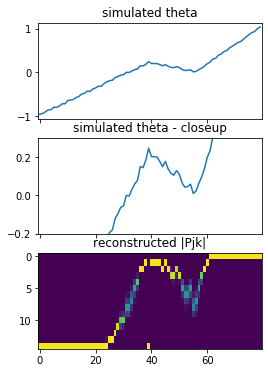

In [41]:
%matplotlib inline
fix, ax = plt.subplots(nrows=3, sharex=True, figsize=(4,6))
ax[0].plot(o)
ax[1].plot(o)
ax[1].set_ylim([-.2,.3])
ax[2].imshow(np.flipud(np.abs(Pjk)), aspect='auto')
ax[0].set_title('simulated theta')
ax[1].set_title('simulated theta - closeup')
ax[2].set_title('reconstructed |Pjk|')